In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import os
import virtual_biopsy_utils as vbu
import integration_images_features_utils as image_utils
import ast
import delong

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, brier_score_loss, precision_score, recall_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import shap

In [2]:
def get_pretty_names_dict():
    return pd.read_csv('../assisting_docs/features_dictionary.csv', index_col = 0, squeeze=True).to_dict()

### Load files ready to be trained

In [3]:
x_train = pkl.load(open('../pkls/x_train_ready_for_training.pkl', 'rb'))
y_train = pkl.load(open('../pkls/y_train_ready_for_training.pkl', 'rb'))

x_val = pkl.load(open('../pkls/x_val_ready_for_training.pkl', 'rb'))
y_val = pkl.load(open('../pkls/y_val_ready_for_training.pkl', 'rb'))


### Load shap clinical features

In [4]:
shap_feats = pkl.load(open('../pkls/sentara_union_shap.pkl', 'rb'))

shap_feats = list(set(shap_feats))

### Drop features we don't want to use

In [5]:

# if clinical only
predictions = [x for x in x_train if 'pred' in x]
x_train.drop(columns=['study_id'] + predictions, inplace=True) #studyid
x_val.drop(columns=['study_id']+ predictions, inplace=True)


# if shap features only

# x_train = x_train[shap_feats]
# x_val = x_val[shap_feats]

#if images only (small set):

# imaging_feats = [x for x in x_train if 'pred' in x]
# x_train = x_train[imaging_feats]
# x_val = x_val[imaging_feats]

# shap clinical + small set images

# imaging_feats = [x for x in x_train if 'pred' in x]
# x_train = x_train [imaging_feats + shap_feats]
# x_val = x_val [imaging_feats + shap_feats]

# shap clinical + full set images

# image_full_set = [x for x in x_train if 'report' in x] + [x for x in x_train if 'calcification_in' in x] + \
# [x for x in x_train if 'findings' in x] + [x for x in x_train if 'pred' in x] + \
# ['Calcification', 'Breast Assymetry', 'Tumor', 'Architectural Distortion', 'Axillary lymphadenopathy']
# x_train = x_train [image_full_set + shap_feats]
# x_val = x_val [image_full_set + shap_feats]

# if annotations only

# annotations = [x for x in x_train if 'report' in x] + [x for x in x_train if 'calcification_in' in x] + \
# [x for x in x_train if 'findings' in x] + \
# ['Calcification', 'Breast Assymetry', 'Tumor', 'Architectural Distortion', 'Axillary lymphadenopathy']
# x_train = x_train [annotations ]
# x_val = x_val [annotations ]


In [6]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(1729, 1829) (357, 1829) (1729, 5) (357, 5)


### XGBoost

In [7]:
NUM_ITER = 10

In [8]:
# Make sure columns have the same order
x_val = x_val[x_train.columns]

In [9]:
classes = ['outcome_cancer_type_DCIS', 'outcome_cancer_type_Invasive', 'outcome_cancer_type_BenignHR',
           'outcome_cancer_type_Papilloma', 'outcome_cancer_type_Benign']

XGB = XGBClassifier( eval_metric = 'auc')


# Grid parameters definition
min_child_weight = [1, 2, 3, 5, 7]  
gamma= [0, 0.1, 0.2, 0.3, 0.4]
colsample_bytree= [0.3, 0.4, 0.5, 0.7, 1.0]
learning_rate= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50]  
max_depth= [3, 4, 5, 6, 7, 8, 10] 


grid_params_xgb = {'min_child_weight': min_child_weight,
                 'gamma': gamma,
                 'colsample_bytree': colsample_bytree,
                 'learning_rate': learning_rate,
                 'max_depth': max_depth}

XGB_CV= RandomizedSearchCV(estimator = XGB,
                 param_distributions = grid_params_xgb,
                 scoring = 'roc_auc', n_iter = 30, 
                 cv=5) 


stats_runs = {}
stats_runs['AUC_mean'] = []
stats_runs['AUC_CI1'] = []
stats_runs['AUC_CI2'] = []
stats_runs['probabilities'] = []


for i in range(NUM_ITER):
    
    print ('{}/{}\r'.format(i+1, NUM_ITER), end = '', flush=True)

    for category in classes:
    
        print('**Processing class {} ...**'.format(category))
        
        XGB_CV.fit(x_train, y_train[category])
        y_pred = XGB_CV.predict(x_val)

        prob = XGB_CV.predict_proba(x_val)[:,1]
        
        
        stats_runs['AUC_mean'].append(roc_auc_score(y_val[category], 
                                        prob))
        stats_runs['AUC_CI1'].append(delong.get_delong_ci(prob, y_val[category])[0])
        stats_runs['AUC_CI2'].append(delong.get_delong_ci(prob, y_val[category])[1])                        
        stats_runs['probabilities'].append(prob)

#         print('\tAUC: {:.2f} [{:.2f}, {:.2f}]'.format(roc_auc_score(y_val[category], 
#                                         prob), *delong.get_delong_ci(prob, y_val[category])))
#         print('\n')
        
#         pkl.dump(XGB_CV.best_estimator_, 
#         open('../pkls/cancer_prediction_pkls/xgboost/clinical/model_' + str(category) + '_run_' + str(i) + '.pkl', 'wb')) 
        
        # SHAP

        best_params_grid_search = XGB_CV.best_params_

        model  = XGBClassifier(**best_params_grid_search)
        model.fit(x_train, y_train[category])
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(x_val)
        pkl.dump(shap_values, open('../pkls/cancer_prediction_pkls/xgboost/clinical/shap_values_' + str(category) + '_run_' + str(i) + '.pkl', 'wb'))
 

    # Save probabilities
# np.savetxt('significance_tests/predict_probs_XGBoost_shap_and_predictions_and_annotations.csv', stats_runs['probabilities'], delimiter=',')

**Processing class outcome_cancer_type_DCIS ...**
**Processing class outcome_cancer_type_Invasive ...**
**Processing class outcome_cancer_type_BenignHR ...**
**Processing class outcome_cancer_type_Papilloma ...**
**Processing class outcome_cancer_type_Benign ...**
**Processing class outcome_cancer_type_DCIS ...**
**Processing class outcome_cancer_type_Invasive ...**
**Processing class outcome_cancer_type_BenignHR ...**
**Processing class outcome_cancer_type_Papilloma ...**
**Processing class outcome_cancer_type_Benign ...**
**Processing class outcome_cancer_type_DCIS ...**
**Processing class outcome_cancer_type_Invasive ...**
**Processing class outcome_cancer_type_BenignHR ...**
**Processing class outcome_cancer_type_Papilloma ...**
**Processing class outcome_cancer_type_Benign ...**
**Processing class outcome_cancer_type_DCIS ...**
**Processing class outcome_cancer_type_Invasive ...**
**Processing class outcome_cancer_type_BenignHR ...**
**Processing class outcome_cancer_type_Papillom

In [10]:
outputs = {'DCIS_AUC_mean': stats_runs['AUC_mean'][0::5],
          'DCIS_AUC_lowCI': stats_runs['AUC_CI1'][0::5],
          'DCIS_AUC_highCI': stats_runs['AUC_CI2'][0::5]}
df_DCIS = pd.DataFrame(data=outputs)
df_DCIS
# df_DCIS.to_csv('output_AUCs_all_models/xgboost_DCIS_clinical.csv')

,DCIS_AUC_mean,DCIS_AUC_lowCI,DCIS_AUC_highCI
0,0.565495,0.474257,0.650344
1,0.514885,0.412396,0.610984
2,0.522219,0.422345,0.615703
3,0.474659,0.372642,0.570286
4,0.527157,0.430580,0.617343
5,0.504357,0.409150,0.593174
6,0.511255,0.420269,0.595851
7,0.465800,0.368059,0.557152
8,0.502251,0.402154,0.595958
9,0.495135,0.396504,0.587376


In [11]:
outputs = {'Invasive_AUC_mean': stats_runs['AUC_mean'][1::5],
          'Invasive_AUC_lowCI': stats_runs['AUC_CI1'][1::5],
          'Invasive_AUC_highCI': stats_runs['AUC_CI2'][1::5]}
df_DCIS = pd.DataFrame(data=outputs)
# df_DCIS.to_csv('output_AUCs_all_models/xgboost_Invasive_clinical.csv')
df_DCIS

,Invasive_AUC_mean,Invasive_AUC_lowCI,Invasive_AUC_highCI
0,0.640408,0.568196,0.705156
1,0.651476,0.581810,0.713679
2,0.586617,0.514807,0.650965
3,0.654578,0.583276,0.718418
4,0.641917,0.573508,0.702863
5,0.629926,0.559731,0.692659
6,0.638521,0.567025,0.702554
7,0.658435,0.589010,0.720398
8,0.617810,0.546269,0.681888
9,0.648541,0.578996,0.710623


In [12]:
outputs = {'BenignHR_AUC_mean': stats_runs['AUC_mean'][2::5],
          'BenignHR_AUC_lowCI': stats_runs['AUC_CI1'][2::5],
          'BenignHR_AUC_highCI': stats_runs['AUC_CI2'][2::5]}
df_DCIS = pd.DataFrame(data=outputs)
# df_DCIS.to_csv('output_AUCs_all_models/xgboost_BenignHR_clinical.csv')
df_DCIS

,BenignHR_AUC_mean,BenignHR_AUC_lowCI,BenignHR_AUC_highCI
0,0.621125,0.421472,0.814996
1,0.596689,0.395815,0.791784
2,0.590909,0.399499,0.776539
3,0.563584,0.358021,0.763366
4,0.665791,0.509580,0.816222
5,0.588282,0.394086,0.776697
6,0.630058,0.438234,0.816101
7,0.611666,0.411115,0.806437
8,0.548870,0.369962,0.721998
9,0.583552,0.392746,0.768578


In [13]:
outputs = {'Papilloma_AUC_mean': stats_runs['AUC_mean'][3::5],
          'Papilloma_AUC_lowCI': stats_runs['AUC_CI1'][3::5],
          'Papilloma_AUC_highCI': stats_runs['AUC_CI2'][3::5]}
df_DCIS = pd.DataFrame(data=outputs)
# df_DCIS.to_csv('output_AUCs_all_models/xgboost_Papilloma_clinical.csv')
df_DCIS

,Papilloma_AUC_mean,Papilloma_AUC_lowCI,Papilloma_AUC_highCI
0,0.501692,0.391542,0.605854
1,0.564567,0.445000,0.678145
2,0.574980,0.461544,0.682429
3,0.580187,0.462822,0.691564
4,0.585004,0.474300,0.689720
5,0.585004,0.474300,0.689720
6,0.533715,0.422820,0.638622
7,0.541656,0.426158,0.651165
8,0.569773,0.455792,0.677767
9,0.588519,0.478587,0.692462


In [14]:
outputs = {'Benign_AUC_mean': stats_runs['AUC_mean'][4::5],
          'Benign_AUC_lowCI': stats_runs['AUC_CI1'][4::5],
          'Benign_AUC_highCI': stats_runs['AUC_CI2'][4::5]}
df_DCIS = pd.DataFrame(data=outputs)
# df_DCIS.to_csv('output_AUCs_all_models/xgboost_Benign_clinical.csv')
df_DCIS

,Benign_AUC_mean,Benign_AUC_lowCI,Benign_AUC_highCI
0,0.579256,0.513547,0.632061
1,0.614213,0.549202,0.666320
2,0.611546,0.546586,0.663602
3,0.621638,0.556924,0.673450
4,0.595640,0.530355,0.648022
5,0.606851,0.541697,0.659102
6,0.570233,0.504154,0.623409
7,0.609901,0.544741,0.662157
8,0.598994,0.533751,0.651333
9,0.609901,0.544741,0.662157


### SHAP

For each run, we will analise the top 20 shap features. we take the features that showed up more than half of the times for each class. So if one feature showed up more than 5 times for a specific class, we keep that feature. 

In [15]:
final_features_per_class = []
for category in classes:

    shap_values = []
    top_20_all_shap = []

    for i in range(10):
        shap_values.append(pkl.load(open('../pkls/cancer_prediction_pkls/xgboost/clinical/shap_values_' + str(category) + '_run_' + str(i) + '.pkl', 'rb')))
        top_20_all_shap.append(x_val.columns[np.argsort(np.abs(shap_values[i]).mean(0))].tolist()[::-1][:20])

    top_20_all_shap_flat = [item for sublist in top_20_all_shap for item in sublist]

    final_features_per_class.append(list(set([x for x in top_20_all_shap_flat if top_20_all_shap_flat.count(x) >=5 ])))

union_shap = list(set([item for sublist in final_features_per_class for item in sublist]))

with open('../pkls/sentara_union_shap.pkl', 'wb') as handle:
    pkl.dump(union_shap, handle, protocol=pkl.HIGHEST_PROTOCOL)


['age',
 'age_last_menstruation',
 'labs_liver_levels_ALT (GPT)_last',
 'past_biopsy_proc_cnt',
 'labs_cbc_levels_MCV-Mean Cell Volume',
 'children_cnt',
 'menstruation_years',
 'calc_likelihood_obesity',
 'labs_cbc_levels_MCV-Mean Cell Volume_max',
 'months_since_first_MG',
 'age_first_menstruation',
 'labs_hormone_levels_TSH_last',
 'calc_breast_density_current',
 'menarche_to_ftp_years',
 'calc_bmi_current',
 'labs_blood_chem_levels_Albumin (B)_min',
 'age_first_childbirth',
 'lump_by_dr_ind_current',
 'labs_blood_chem_levels_Albumin (B)',
 'age',
 'dx_V16.3_cnt',
 'months_since_first_MG',
 'labs_kidneys_levels_K+ Potassium (B)_last',
 'labs_hormone_levels_TSH_min',
 'lump_by_dr_cnt',
 'lump_by_dr_ind_current',
 'labs_kidneys_levels_K+ Potassium (B)',
 'labs_cbc_levels_Hemoglobin_min',
 'complaint_ind_current',
 'prev_benign_cnt',
 'age_first_childbirth',
 'labs_lipids_levels_Cholesterol_max',
 'menstruation_years',
 'labs_blood_chem_levels_Ca-Calcium (B)_last',
 'children_cnt',
 'l

### DCIS

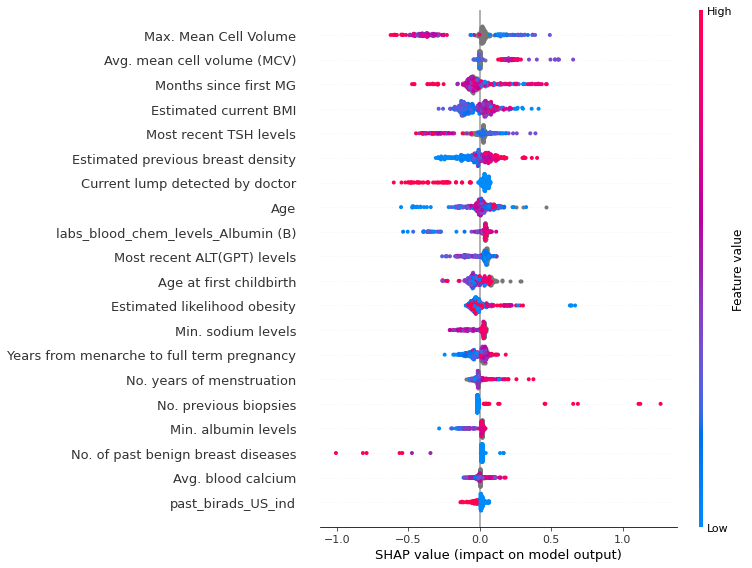

In [19]:
dcis = pd.read_csv('output_AUCs_all_models/xgboost_DCIS_clinical.csv', index_col =0) 
idx = dcis['DCIS_AUC_mean'].argmax()
dcisshap = pkl.load(open('../pkls/cancer_prediction_pkls/xgboost/clinical/shap_values_outcome_cancer_type_DCIS_run_'+ str(idx)+'.pkl', 'rb'))
val_disp = x_val.rename(columns=get_pretty_names_dict())
shap.summary_plot(dcisshap, val_disp, max_display = 20, plot_type='dot',show=False)

# plt.savefig("../RESULTS/Figures/shap_DCIS_Sentara_summary.eps", format="eps", dpi=600, bbox_inches="tight")
# plt.savefig("../RESULTS/Figures/shap_DCIS_Sentara_summary.png", format="png", dpi=600, bbox_inches="tight")

In [ ]:
# d = pd.read_csv('../assisting_docs/features_dictionary.csv', index_col=1, squeeze=True).to_dict()
# d 
# add = pd.DataFrame([['family_breast_cancer_ind', 'Has family member with BC'],
#                     ['labs_immune_levels_Basophils #', 'Avg. # basophils levels'],
#                     ['past_biopsy_proc_cnt', 'No. previous biopsies'],
#                    ['smoking_years_past', 'No. years smoked']])
# d.columns = ['0', '1']
# add.columns = ['0', '1']
# d.append(add).reset_index(drop=True).to_csv('../assisting_docs/features_dictionary.csv')

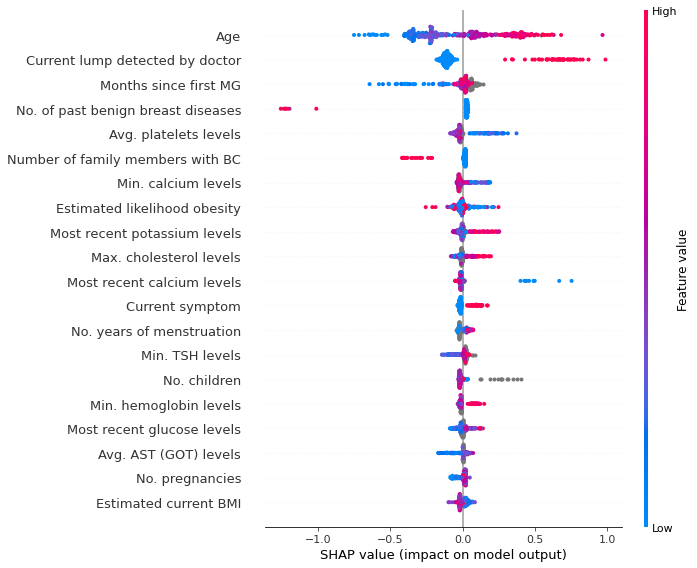

In [20]:
inv = pd.read_csv('output_AUCs_all_models/xgboost_Invasive_clinical.csv', index_col =0) 
idx = inv['Invasive_AUC_mean'].argmax()
invshap = pkl.load(open('../pkls/cancer_prediction_pkls/xgboost/clinical/shap_values_outcome_cancer_type_Invasive_run_'+ str(idx)+'.pkl', 'rb'))
val_disp = x_val.rename(columns=get_pretty_names_dict())
shap.summary_plot(invshap, val_disp, max_display = 20, plot_type='dot',show=False)

# plt.savefig("../RESULTS/Figures/shap_Invasise_Sentara_summary.eps", format="eps", dpi=600, bbox_inches="tight")
# plt.savefig("../RESULTS/Figures/shap_Invasise_Sentara_summary.png", format="png", dpi=600, bbox_inches="tight")

### BenignHR

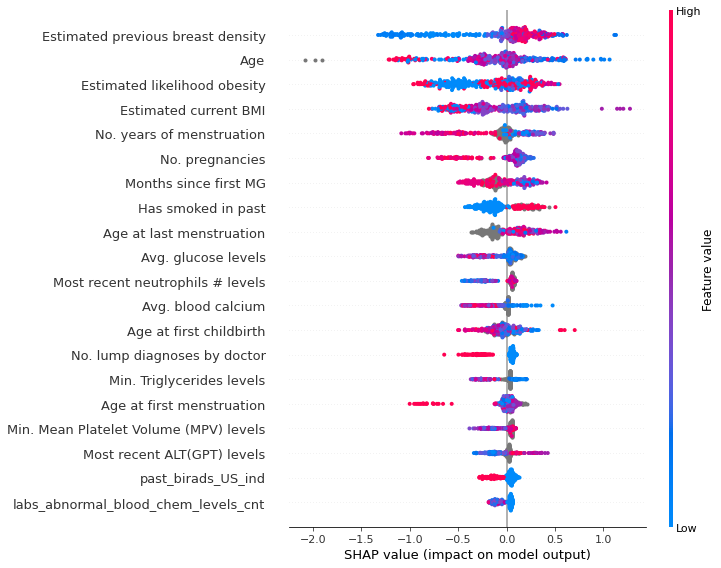

In [21]:
benhr = pd.read_csv('output_AUCs_all_models/xgboost_BenignHR_clinical.csv', index_col =0) 
idx = benhr['BenignHR_AUC_mean'].argmax()
benhrshap = pkl.load(open('../pkls/cancer_prediction_pkls/xgboost/clinical/shap_values_outcome_cancer_type_BenignHR_run_'+ str(idx)+'.pkl', 'rb'))
val_disp = x_val.rename(columns=get_pretty_names_dict())
shap.summary_plot(benhrshap, val_disp, max_display = 20, plot_type='dot',show=False)

# plt.savefig("../RESULTS/Figures/shap_BenignHR_Sentara_summary.eps", format="eps", dpi=600, bbox_inches="tight")
# plt.savefig("../RESULTS/Figures/shap_BenignHR_Sentara_summary.png", format="png", dpi=600, bbox_inches="tight")

### Papilloma

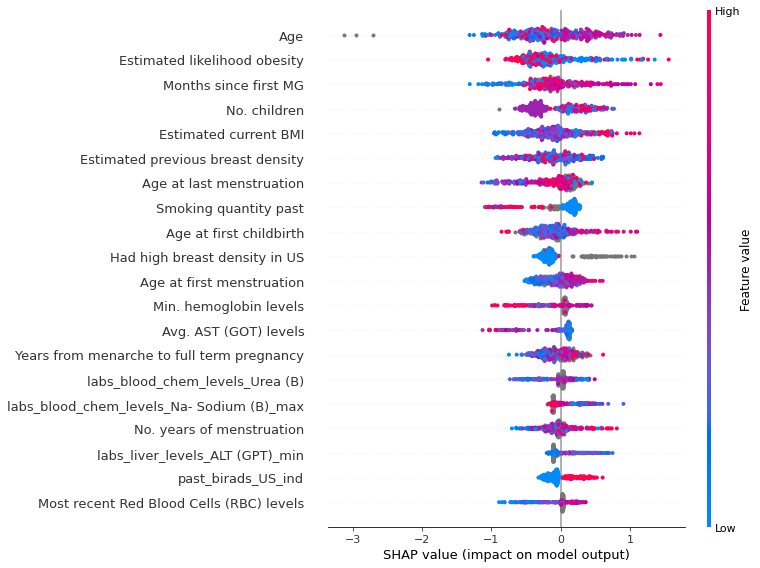

In [22]:
pap = pd.read_csv('output_AUCs_all_models/xgboost_Papilloma_clinical.csv', index_col =0) 
idx = pap['Papilloma_AUC_mean'].argmax()
papshap = pkl.load(open('../pkls/cancer_prediction_pkls/xgboost/clinical/shap_values_outcome_cancer_type_Papilloma_run_'+ str(idx)+'.pkl', 'rb'))
val_disp = x_val.rename(columns=get_pretty_names_dict())
shap.summary_plot(papshap, val_disp, max_display = 20, plot_type='dot', show=False)

# plt.savefig("../RESULTS/Figures/shap_Papilloma_Sentara_summary.eps", format="eps", dpi=600, bbox_inches="tight")
# plt.savefig("../RESULTS/Figures/shap_Papilloma_Sentara_summary.png", format="png", dpi=600, bbox_inches="tight")

### Benign

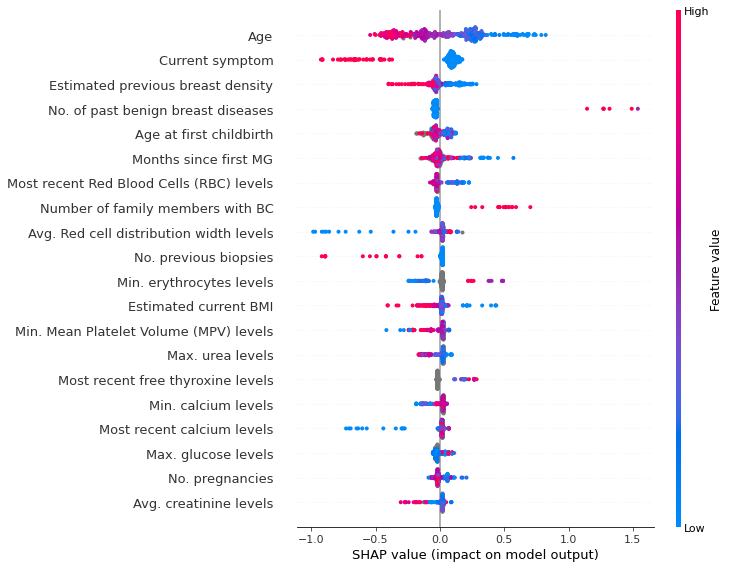

In [23]:
ben = pd.read_csv('output_AUCs_all_models/xgboost_Benign_clinical.csv', index_col =0) 
idx = ben['Benign_AUC_mean'].argmax()
benshap = pkl.load(open('../pkls/cancer_prediction_pkls/xgboost/clinical/shap_values_outcome_cancer_type_Benign_run_'+ str(idx)+'.pkl', 'rb'))
val_disp = x_val.rename(columns=get_pretty_names_dict())
shap.summary_plot(benshap, val_disp, max_display = 20, plot_type='dot',show=False)

# plt.savefig("../RESULTS/Figures/shap_Benign_Sentara_summary.eps", format="eps", dpi=600, bbox_inches="tight")
# plt.savefig("../RESULTS/Figures/shap_Benign_Sentara_summary.png", format="png", dpi=600, bbox_inches="tight")

In [ ]:
d = pd.read_csv('../assisting_docs/features_dictionary.csv', index_col = 0, squeeze=True).to_dict()
# d.drop(columns = 'Unnamed: 0', inplace=True)
# d.to_csv('../assisting_docs/features_dictionary.csv')
# d[d['1'].str.contains('menarche_to_ftp_years')]
# d.drop(columns = ['Unnamed: 0'], inplace = True)
# d.to_csv('../assisting_docs/features_dictionary.csv')
# add = pd.DataFrame([
#                 ['calc_bmi_current', 'Estimated current BMI'], 
#                    ['calc_likelihood_obesity', 'Estimated likelihood obesity'],
#                     ['menarche_to_ftp_years', 'Years from menarche to full term pregnancy'],
#                     ['calc_breast_density_current', 'Estimated previous breast density'],
#                     ['past_biopsy_proc_count', 'No. past biopsies'],
#                     ['dx_V16.3_cnt', 'Number of family members with BC'],
#                     ['labs_urinalysis_levels_Erythrocytes (U)_min', 'Min. erythrocytes levels'],
#                     ['labs_lipids_levels_Cholesterol_max', 'Max. cholesterol levels'],
#                    ['labs_cbc_levels_Hematocrit_max', 'Max. hematocrit levels'],
#                    ['labs_cbc_levels_MPV-Mean Platelet Volume_min', 'Min. Mean Platelet Volume (MPV) levels'],
#                    ['labs_cbc_levels_RBC-Red Blood Cells_last', 'Most recent Red Blood Cells (RBC) levels'],
#                    ['labs_hormone_levels_Free Thyroxine (FT4)_last', 'Most recent free thyroxine levels'],
#                    ['labs_lipids_levels_HDL-Cholesterol_last', 'Most recent cholesterol levels'],
#                    ['labs_urinalysis_levels_Erythrocytes (U)_last', 'Most recent erythrocytes levels'],
#                    ['smoking_years_past', 'Years smoked'],
#                    ['family_cancer_ind', 'Has family members with cancer'],
#                    ['labs_immune_levels_Monocytes %_min', 'Min. monocytes levels'],
#                     ['labs_cbc_levels_Hematocrit_last', 'Most recent hematocrit levels'],
#                    ['labs_immune_levels_Eosinophils %', 'Avg. eosinophils levels (%)'],
#                    ['labs_kidneys_levels_Creatinine (B)', 'Avg. creatinine levels'],
#                    ['labs_liver_levels_AST (GOT)_min', 'Min. AST (GOT) levels'],
#                    ['labs_immune_levels_Eosinophils #_min', 'Min. count eosinophils levels'],
#                    ['labs_misc_levels_Ferritin_max', 'Max. ferritin levels'],
#                    ['labs_cbc_levels_MPV-Mean Platelet Volume_max', 'Max. Mean Platelet Volume (MPV) levels'],
#                    ['labs_urinalysis_levels_Protein (U)_last', 'Most recent urinalysis protein levels'],
#                    ['labs_blood_chem_levels_Glucose (B)_max', 'Max. glucose levels'],
#                    ['labs_immune_levels_Monocytes #_min', 'Min. monocytes # levels'],
#                    ['labs_misc_levels_Vitamin B12', 'Avg. vitamin b12 levels'],
#                    ['labs_cbc_levels_Hemoglobin_max', 'Max. hemoglobin levels'],
#                    ['labs_kidneys_levels_Creatinine (B)_last', 'Most recent creatinine levels'],
#                    ['labs_blood_chem_levels_HbA1C_max', 'Max. hemoglobin A1C levels']
#                    ])
# d.columns = ['0', '1']
# add.columns = ['0', '1']
# # pd.concat([d, add], axis = 0)
# c = d.reset_index(drop=True).append(add).reset_index(drop=True)
# c.to_csv('../assisting_docs/features_dictionary.csv')
# d.append(add)
# .reset_index(drop=True).to_csv('../assisting_docs/features_dictionary.csv')

In [ ]:
add = pd.DataFrame([['calc_bmi_current', 'Estimated current BMI'], 
                   ['calc_likelihood_obesity', 'Estimated likelihood obesity'],
            ['menarche_to_ftp_years', 'Years from menarche to full term pregnancy'],
            ['calc_breast_density_current', 'Estimated previous breast density'],
            ['smoking_qnt_past', 'Smoking quantity past'],
            ['months_since_first_MG', 'Months since first MG'],
            ['labs_cbc_levels_MCV-Mean Cell Volume_max', 'Max. Mean Cell Volume'],
            ['labs_lipids_levels_Triglycerides_min', 'Min. Triglycerides levels'],
            ['labs_lipids_levels_Cholesterol', 'Avg. Cholesterol levels'],
            ['labs_cbc_levels_RDW-Red Cell Distri.Width_max', 'Max. Red Cell Distr. Width (RDW)'],
            ['labs_kidneys_levels_K+ Potassium (B)_min', 'Min. potassium levels'],
            ['labs_cbc_levels_Platelets', 'Avg. platelets levels'],
            ['labs_blood_chem_levels_Ca-Calcium (B)_min', 'Min. calcium levels'],
            ['labs_blood_chem_levels_Ca-Calcium (B)_last', 'Most recent calcium levels'],
            ['labs_liver_levels_AST (GOT)', 'Avg. AST (GOT) levels'],
            ['labs_cbc_levels_Platelets_min', 'Min. platelets levels'],
            ['labs_cbc_levels_Platelets_last', 'Most recent platelets levels'],
            ['children_cnt', 'No. children'],
             ['smoking_ind_past', 'Has smoked in past'],
             ['labs_cbc_levels_MPV-Mean Platelet Volume', 'Avg. Mean Platelet Vol (MPV)'],
             ['labs_liver_levels_ALT (GPT)_last', 'Most recent ALT(GPT) levels'],
             ['past_birads_US_high_ind', 'Had high breast density in US'],
             ['labs_blood_chem_levels_Urea (B)_max', 'Max. urea levels'],
             ['labs_blood_chem_levels_Urea (B)_min', 'Min. urea levels'],
             ['labs_blood_chem_levels_Na- Sodium (B)', 'Avg. sodium levels'],
             ['labs_liver_levels_ALKP-Alkaline Phosphatase_min', 'Min. alkaline phosphatase levels']])
d.append(add).reset_index(drop=True).to_csv('../assisting_docs/features_dictionary.csv')